**ITS_LIVE Python Library Demo: Time Series of Ice Flow Speed at a Point**

ITS_LIVE (Intermission Time Series of Land Ice Velocity and Elevation, http:itslive.jpl.nasa.gov) maintains an archive of ice flow speeds for glaciers and ice sheets.
These speeds are determined from pairs of satellite images by tracking how far features move from the first image in a pair to the second image in a pair.

As a result, the time series of ice motion at a single location on a glacier consist of measurements of the average speed of the ice at that point over the time interval between the two images used. In the plot generated below, color represents the time separation of the two images used (also visible as the length of the line segment for each point), the vertical position of that line segment shows the average speed over that interval in meters per year, and dates of the two images determine the start and end points of the line segment.

In [1]:
%matplotlib inline

# uses multicolor line solution from: 
# https://stackoverflow.com/questions/44642966/how-to-plot-multi-color-line-if-x-axis-is-date-time-index-of-pandas

import itslive

# we need several matplotlib components to make this plot
from matplotlib import pyplot as plt
from matplotlib import collections  as mc
from matplotlib import dates as mdates
from matplotlib import colors as mpl_colors
from matplotlib import cm  as mpl_cm
from matplotlib import ticker as mpl_ticker

import numpy as np


In [2]:
sample_point_longitude_latitude = (-140.51,60.07)


points_timeseries_list = itslive.velocity_cubes.get_time_series(points=[sample_point_longitude_latitude],variables = [ 'v', 'acquisition_date_img1', 'acquisition_date_img2', 'date_dt'])

point_timeseries = points_timeseries_list[0] # we only specified one point so it is the first (only) one in the list of timeseries

# each timeseries is returned as a dictionary containing the requested location and timeseries for each variable in a subdictionary
timeseries_dict = point_timeseries['time_series']


In [3]:
# set up color mapping for coloring line segments by del_tdays
max_dt = 90
min_dt = 5
norm = mpl_colors.Normalize(vmin=min_dt, vmax=max_dt, clip=True)
mapper = mpl_cm.ScalarMappable(norm=norm, cmap=mpl_cm.jet)


In [4]:
# make list of tuples (del_tdays first(for sorting for plot, so that short inervals plot last), v, then [(time1,v), (time2,v)] line segment coordinates)
#  exclude points with time intervals greater than max_dt or shorter than min_dt, and points where v is a nan (no data)
#       times are converted using mdates from np.datetime64 values to a date format that works in LineCollection/pyplot to make x time axis 
#       (this is a hack needed for linecollection - np.datetime64 values work for fine for plt.plot...)
lines_tuples = [(del_tdays,v,[(t1,v),(t2,v)]) for t1,t2,v,del_tdays in zip(
                                                                            mdates.date2num(timeseries_dict.acquisition_date_img1.values),
                                                                            mdates.date2num(timeseries_dict.acquisition_date_img2.values),
                                                                            timeseries_dict.v.values,
                                                                            np.round(timeseries_dict.date_dt.values.astype('timedelta64[s]').astype(float)/(24.0*3600.0)).astype(int)
                                                                            ) 
                                                                    if del_tdays<=max_dt and del_tdays>=min_dt and not np.isnan(v)]


In [5]:
# this sort puts the shorter del_t (pair time separation) line segments later in the list so they plot on top of the longer ones
lines_tuples.sort(reverse=True)

# the next line returns vectors for each element in the tuples list (goes from one tuple per line segment to vectors of delt, v, and the two tuples per line)
delt,v,lines = zip(*lines_tuples)

# make vector of colors for the line segments
dt_colors = mapper.to_rgba(delt)

# make a matplotlib line collection from these segments
lc = mc.LineCollection(lines, color=dt_colors)

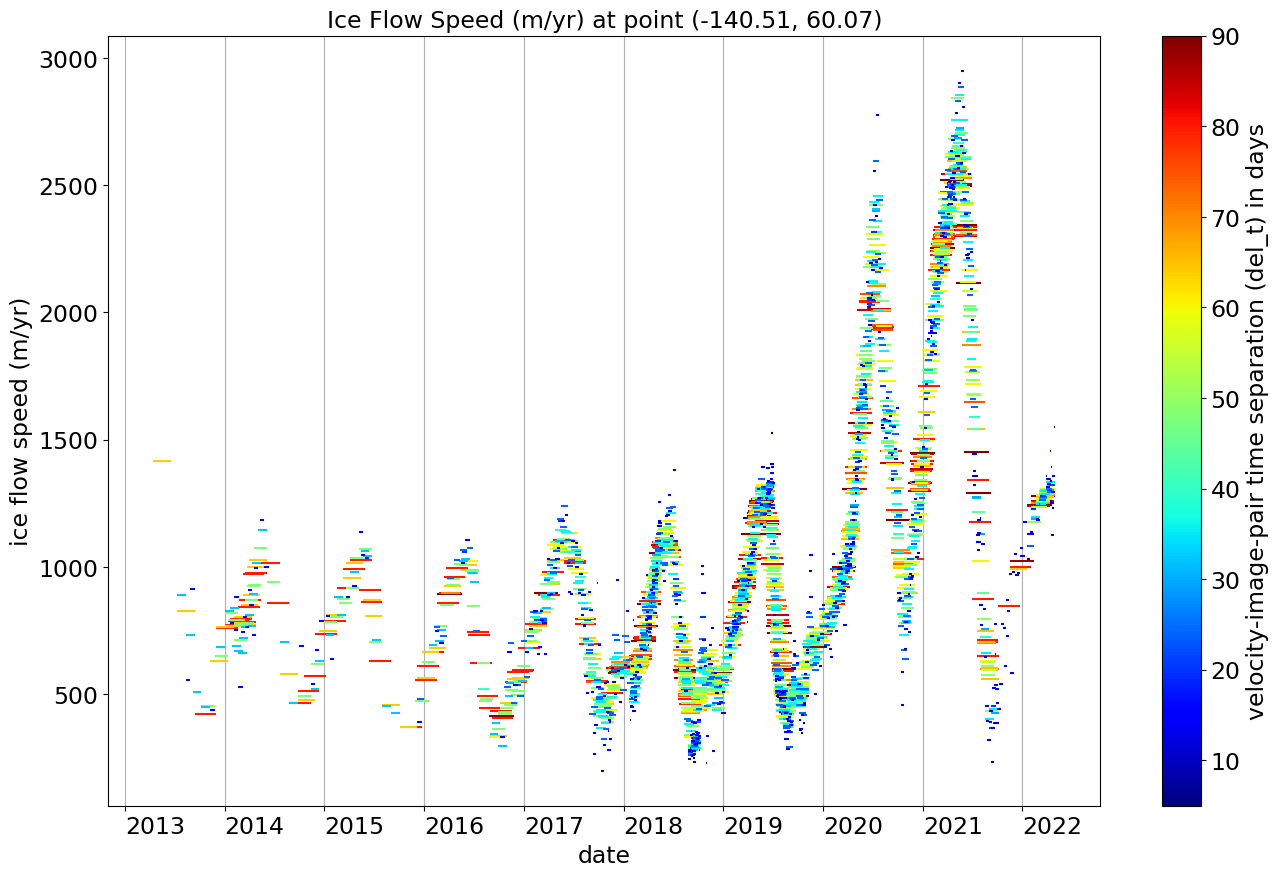

In [6]:
# create the figure and axis for plot
fig,ax = plt.subplots(figsize=[16,10])
# plot the line collection that was created in the previous cell
ax.add_collection(lc)

ax.set_title(f'Ice Flow Speed (m/yr) at point {sample_point_longitude_latitude}',fontsize='x-large')

# the rest of this cell is to format the axes tickmarks and labels (date format, placement and size)
ax.xaxis.set_major_locator(mdates.YearLocator())
yearFmt = mdates.DateFormatter('%Y')
ax.xaxis.set_major_formatter(yearFmt)
plt.grid(visible=None, which='major', axis='x')
ax.autoscale_view()
cb2 = plt.colorbar(mapper,ax=ax,label='velocity-image-pair time separation (del_t) in days')
ax.set_xlabel('date')
ax.set_ylabel('ice flow speed (m/yr)')

# make the axes labels and values larger
y_formatter = mpl_ticker.ScalarFormatter(useOffset=False)
ax.yaxis.set_major_formatter(y_formatter)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label, cb2.ax.get_yaxis().get_label()] +
             ax.get_xticklabels() + ax.get_yticklabels() + cb2.ax.get_yticklabels()):
    item.set_fontsize(17)

# shift year labels so they are left justified against the start of the year - year number is then within the year it should be
for label in ax.get_xticklabels():
        label.set_horizontalalignment('left')

Shorter (blue) line segments are from image pairs only separated in time by a few to a few tens of days. These shorter segments can reveal rapid transients in ice flow speed due to rain storms or strong melt events.

Longer segments (red in this plot) average out these transients, but provide a less noisy picture of ice flow speed.

Note that we have selected 90 days as the longest time interval shown in this plot (max_dt = 90 above) - ITS_LIVE processes image pairs out to 545 days time separation, which can provide longer-term average ice flow speed, but the ability to track features over longer times successfully is limited by changes in the surface of the ice, so the numer of longer time measurements is significantly smaller than the shorter intervals.